## 2. Load the Cleaned Dataset

In [17]:
!pip install scikit-learn==1.5.2 imbalanced-learn==0.12.3
# 📦 Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import TomekLinks
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

# ✅ Load dataset
file_path = 'missingvaluesdone.csv'
df = pd.read_csv(file_path)
print("Initial shape:", df.shape)
df.head()


Initial shape: (9393, 38)


,age,sex,heart_axis,RR_mean,RR_std,HR,QRS_duration,l5_QRS_duration,PR_interval,l5_PR_interval,...,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings,condition
0,54.0,0,LAD,970.000000,17.029386,61.855670,97.777778,93.200000,191.111111,188.400000,...,0.386047,2.929688,5.650555,-3.534950e-17,-0.153010,1.0,4.241455,25.360262,77.0,Normal
1,48.0,0,LAD,814.363636,15.155393,73.677160,107.500000,92.333333,194.333333,214.166667,...,1.364808,4.882812,5.293184,-1.278977e-17,-0.280783,1.0,2.106691,5.721974,78.0,MI
2,56.0,0,LAD,681.538462,2.499704,88.036117,115.000000,101.000000,196.000000,202.285714,...,1.181564,1.464844,5.117901,-9.947598e-18,0.071950,1.0,0.243890,4.556635,75.0,Normal
3,56.0,0,LAD,962.000000,53.690471,62.370062,95.400000,90.800000,194.600000,173.000000,...,1.816331,0.976562,5.273018,-4.760636e-17,-0.268608,1.0,2.175067,6.217853,78.0,Normal
4,56.0,0,LAD,679.000000,6.129554,88.365243,92.666667,87.466667,203.866667,192.400000,...,0.402798,1.464844,5.489678,-3.552714e-18,0.044945,1.0,0.863977,7.894348,93.0,Normal


## 3. Stratified Sampling on Imbalanced Class

In [18]:
# ✅ Define target column (adjust if your target is different)
target = 'condition'
y = df[target]
X = df.drop(columns=[target])

# ✅ Stratified train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)
print("Class distribution in train set:")
print(y_train.value_counts(normalize=True))

Training set shape: (7514, 37)
Testing set shape: (1879, 37)
Class distribution in train set:
condition
Normal    0.665158
MI        0.307958
CAD       0.026883
Name: proportion, dtype: float64


## 4. One-Hot Encoding for Categorical Predictors

In [19]:
# ✅ Identify all categorical columns
categorical_cols = ['sex', 'heart_axis']  # add others if present

# ✅ Apply One-Hot Encoding to all categorical columns
encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
encoded_train = encoder.fit_transform(X_train[categorical_cols])
encoded_test = encoder.transform(X_test[categorical_cols])

encoded_train_df = pd.DataFrame(encoded_train, columns=encoder.get_feature_names_out(categorical_cols), index=X_train.index)
encoded_test_df = pd.DataFrame(encoded_test, columns=encoder.get_feature_names_out(categorical_cols), index=X_test.index)

# ✅ Merge encoded columns back
X_train = X_train.drop(columns=categorical_cols).join(encoded_train_df)
X_test = X_test.drop(columns=categorical_cols).join(encoded_test_df)

print("After encoding:", X_train.shape)


After encoding: (7514, 43)


## 5. Normalization / Standardization for Numeric Features

In [22]:

# ✅ Identify numeric columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# ✅ Standardize features
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Standardization completed.")



Standardization completed.


## 6. Balancing the Dataset using SMOTE

In [24]:
from imblearn.combine import SMOTETomek

# ⚠️ Check for and handle any remaining missing values
print("NaNs in X_train:", X_train.isnull().sum().sum())

# Option 1: Drop rows with NaN (only if very few)
# X_train = X_train.dropna()

# Option 2: Fill with 0 (safe for scaled data)
X_train = X_train.fillna(0)

# Now apply SMOTE+Tomek
smote_tomek = SMOTETomek(random_state=42)
X_train_res, y_train_res = smote_tomek.fit_resample(X_train, y_train)





NaNs in X_train: 1025


## 7. Correlation Matrix & Feature Drop

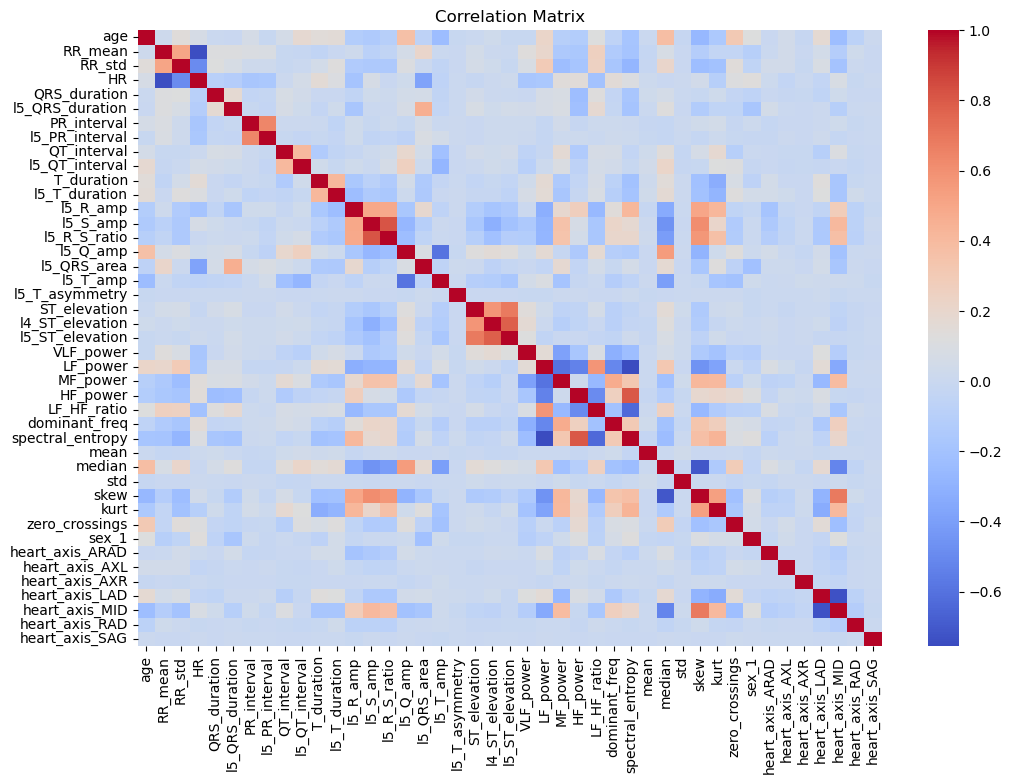

Dropped highly correlated features: set()
New shape after feature drop: (14912, 43)


In [27]:

# Compute correlation matrix
corr_matrix = pd.DataFrame(X_train_res, columns=X_train.columns).corr()

# Plot heatmap
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Drop features with high correlation (>0.9)
threshold = 0.9
to_drop = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > threshold:
            to_drop.add(corr_matrix.columns[i])

X_train_res = pd.DataFrame(X_train_res, columns=X_train.columns).drop(columns=to_drop)
X_test = X_test.drop(columns=to_drop)

print("Dropped highly correlated features:", to_drop)
print("New shape after feature drop:", X_train_res.shape)


In [ ]:
df.head()

,age,sex,heart_axis,RR_mean,RR_std,HR,QRS_duration,l5_QRS_duration,PR_interval,l5_PR_interval,...,LF_HF_ratio,dominant_freq,spectral_entropy,mean,median,std,skew,kurt,zero_crossings,condition
0,54.0,0,LAD,970.000000,17.029386,61.855670,97.777778,93.200000,191.111111,188.400000,...,0.386047,2.929688,5.650555,-3.530000e-17,-0.153010,1.0,4.241455,25.360262,77.0,Normal
1,48.0,0,LAD,814.363636,15.155393,73.677160,107.500000,92.333333,194.333333,214.166667,...,1.364808,4.882812,5.293184,-1.280000e-17,-0.280783,1.0,2.106691,5.721974,78.0,MI
2,56.0,0,LAD,681.538462,2.499704,88.036117,115.000000,101.000000,196.000000,202.285714,...,1.181564,1.464844,5.117901,-9.950000e-18,0.071950,1.0,0.243890,4.556635,75.0,Normal
3,56.0,0,LAD,962.000000,53.690471,62.370062,95.400000,90.800000,194.600000,173.000000,...,1.816331,0.976562,5.273018,-4.760000e-17,-0.268608,1.0,2.175067,6.217853,78.0,Normal
4,56.0,0,LAD,679.000000,6.129554,88.365243,92.666667,87.466667,203.866667,192.400000,...,0.402798,1.464844,5.489678,-3.550000e-18,0.044945,1.0,0.863977,7.894348,93.0,Normal


## 8. Outlier Removal using Z-score Method

In [ ]:

# Apply z-score filtering (|z| > 3 considered an outlier)
z_scores = np.abs(stats.zscore(X_train_res))
filtered_entries = (z_scores < 3).all(axis=1)
X_train_res = X_train_res[filtered_entries]
y_train_res = y_train_res[filtered_entries]

print("Shape after outlier removal:", X_train_res.shape)


Shape after outlier removal: (9182, 42)


## 9. Save the Preprocessed Dataset

In [ ]:

# Combine final train and test datasets for saving
train_final = X_train_res.copy()
train_final['condition'] = y_train_res

test_final = X_test.copy()
test_final['condition'] = y_test

# train_final.to_csv('ECG_train_preprocessed.csv', index=False)
# test_final.to_csv('ECG_test_preprocessed.csv', index=False)

print("✅ Preprocessed train and test datasets saved.")


NameError: name 'X_train_res' is not defined

In [ ]:
train_final.head()

NameError: name 'train_final' is not defined